## Super Resolution

* First, I will train the generative network by minimizing MSE loss(done)
* Next, I will add the GAN loss and train again
* Third, I will try convolutional layers in the networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

In [2]:
import os
import shutil

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# for models
from models import *
import mymnist

In [16]:
batch_size = 32
lr = 0.01
use_cuda = torch.cuda.is_available()

## Train

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def save_checkpoint(state, is_best, filename='G.pth.tar'):
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    print('==> Saving checkpoint')
    torch.save(state, 'checkpoint/' + filename)
    if is_best:
        print('This is best checkpoint ever, copying')
        shutil.copyfile('checkpoint/'+filename, 'checkpoint/'+'G_best.pth.tar')

In [5]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    global lr
    lr = lr * (0.2**(epoch // 10))
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = lr

In [6]:
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting Training Epoch {}'.format(epoch))
    
    losses = AverageMeter()
    
    model.train()  # Set the model to be in training mode
    
    for batch_index, (inputs, targets) in enumerate(train_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # update loss
        losses.update(loss.data[0], inputs.size(0))
        
        # Backward
        optimizer.zero_grad()  # Set parameter gradients to zero
        loss.backward()        # Compute (or accumulate, actually) parameter gradients
        optimizer.step()       # Update the parameters
        
    print('==> Train Epoch : {}, Average loss is {}'.format(epoch, losses.avg))

In [7]:
def validate(validate_loader, model, criterion, epoch):   
    
    print('==> Starting validate')
    model.eval()
    
    losses = AverageMeter()
    
    correct = 0
    
    for batch_idx, (inputs, targets) in enumerate(validate_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # update loss, accuracy
        losses.update(loss.data[0], inputs.size(0))
        
    print('==> Validate Epoch : {}, Average loss, {:.4f}\n'.format(
        epoch,losses.avg))
    
    return losses.avg

## Visualization

In [8]:
def imshow(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()

## Main function

In [38]:
# mode : MSE, GAN 
def main(mode = 'MSE', resume = False):
    
    print('==> Setting parameters')
    start_epoch = 0
    lr = 1e-2
    betas=(0.9, 0.999)
    epochs = 10
    best_prec1 = 10  
    
    print('lr : {}, betas : {}'.format(lr, betas))
    print('Epochs : {}, best_prec1 : {}'.format(epochs, best_prec1))

    
    print('==> Detecting GPU')
    
    print(use_cuda)
    print('\n')
    
    
    print('==> Preparing models')  
    
    G = Adversarial_G()
    
    if use_cuda:
        G.cuda()
        cudnn.benchmark = True
        
    # to be done for both G and D
    # here I only do for G
    if resume:
        if os.path.isfile('checkpoint/'+ resume):
            print("==> loading checkpoint {}".format(resume))
            checkpoint = torch.load('checkpoint/'+ resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            G.load_state_dict(checkpoint['state_dict'])
            print('==> {} has been loaded'.format(resume))
        else:
            print("=> no checkpoint found")
    print('\n')
    
    # dataloader 
    mnist = mymnist.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))
    loader = torch.utils.data.DataLoader(mnist,batch_size=batch_size, shuffle=True)
    
    validate_mnist = mymnist.MNIST('data', download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                   ]))
    validate_loader = torch.utils.data.DataLoader(validate_mnist,batch_size=batch_size, shuffle=True)

    # MSE loss
    criterionG = nn.MSELoss()
    optimizerG = torch.optim.Adam(G.parameters(), lr,
                                     betas = betas, weight_decay=5e-4)
    

    if mode == 'MSE':
        print('Train with MSE loss')
        print('==========================')
        validate_loss_curve = []
        
        for epoch in range(start_epoch, epochs):
            # train for one epoch
            adjust_learning_rate(optimizerG, epoch)
            train(loader, G, criterionG, optimizerG, epoch)
            prec1 = validate(validate_loader, G, criterionG, epoch)
            
            validate_loss_curve += [prec1]
            # remember minimal loss and save checkpoint
            # only G network
            is_best = prec1 < best_prec1
            best_prec1 = min(prec1, best_prec1)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': G.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)
            
        plt.plot(validate_loss_curve)
        plt.ylabel('validate error')
        plt.xlabel('epochs')
        plt.show()
            
    elif mode == 'GAN':
        print('Train with GAN')
        
        Diters = 5
        #clamp_lower = -0.01, clamp_upper = 0.01
        ratio = 1e-2
        lrG = 1e-3
               
        D = Adversarial_D(input_size = 28)
        optimizerD = torch.optim.RMSprop(D.parameters(), lr = lrG)
        criterionD = nn.BCELoss()
        if use_cuda:
            D.cuda()
        
        for param_group in optimizerG.state_dict()['param_groups']:
            param_group['lr'] = lrG
        
        labels = torch.FloatTensor(batch_size) 
        labels = Variable(labels)
        
        real_label = 1
        fake_label = 0
        
        flag = True
        
        isstart = True
        for epoch in range(start_epoch, start_epoch+5):
            
            print('==> Starting Epoch {}'.format(epoch))
            data_iter = iter(loader)
            i = 0
            while i < len(loader):
                
                # train D with cross-entropy loss                
                for p in D.parameters(): # reset requires_grad
                    p.requires_grad = True # they are set to False below in netG update
                
                if isstart:
                    Diters = 500
                    isstart = False
                else :
                    Diters = 5
                    
                j = 0    
                while j < Diters and i < len(loader)-1:
                    j += 1    
                
                    # enforce Lipschitz condition by weight clipping 
                    for p in D.parameters():
                        p.data.clamp_(-0.01, 0.01)    
                    
                    data = data_iter.next()
                    i += 1    
                    
                    D.zero_grad()        
                    small_img, origin_img = data
                    if use_cuda:
                        origin_img = origin_img.cuda()
                        small_img = small_img.cuda()
                        
                    # train with origin images
                    origin_img_var = Variable(origin_img)
                    output = D(origin_img_var)
                    labels.data.resize_(output.size()).fill_(real_label)
                    errD_real = criterionD(output, labels)       
                    errD_real.backward()
      
                    # train with generated images
                    small_img_var = Variable(small_img, volatile = True) # totally freeze netG
                    generate_img_var = Variable(G(small_img_var).data)
                    output = D(generate_img_var)
                    labels.data.resize_(output.size()).fill_(fake_label)
                    errD_fake = criterionD(output, labels)     
                    errD_fake.backward()
                    
                    errD = errD_real + errD_fake
                    optimizerD.step()

                
                # update G
                for p in D.parameters():
                    p.requires_grad = False # to avoid computation
                
                G.zero_grad()
        
                data = data_iter.next()
                i += 1 
                
                small_img, origin_img = data
                if use_cuda:
                    origin_img = origin_img.cuda()
                    small_img = small_img.cuda()
                    
                small_img_var, origin_img_var = Variable(small_img), Variable(origin_img)
                generate_img_var = G(small_img_var)
                      
                output = D(generate_img_var)
                labels.data.resize_(output.size()).fill_(real_label) # fake labels are real for generator cost
                
                errG_GAN = ratio * criterionD(output, labels)
                errG_GAN.backward(retain_variables=True)
                
                errG_content = criterionG(generate_img_var, origin_img_var)
                errG_content.backward()
                
                errG = errG_GAN + errG_content

                optimizerG.step()
                
                torch.save({'epoch': epoch + 1,
                            'state_dict': G.state_dict(),
                            'best_prec1': 0,
                           }, 'checkpoint/G_GAN.pth.tar' )
                torch.save({'epoch': epoch + 1,
                            'state_dict': D.state_dict(),
                            'best_prec1': 0,
                           }, 'checkpoint/D_GAN.pth.tar' )
 
    if mode == 'visual' or 'MSE' or 'GAN':
        # visualize the outputs
        print('Visualize the outputs : ')
        G.eval()
        for batch_index, (inputs, targets) in enumerate(loader):
            if batch_index == 0:
                inputs, targets = Variable(inputs), Variable(targets)
                G_outputs = G(inputs)
            
                print('Inputs : ')
                imshow(torchvision.utils.make_grid(inputs.data))
                print('Outputs of G network : ')
                imshow(torchvision.utils.make_grid(G_outputs.data))
                print('Origin :')
                imshow(torchvision.utils.make_grid(targets.data))
                

==> Setting parameters
lr : 0.01, betas : (0.9, 0.999)
Epochs : 10, best_prec1 : 10
==> Detecting GPU
False


==> Preparing models
=> no checkpoint found


Train with MSE loss
Starting Training Epoch 0
==> Train Epoch : 0, Average loss is 0.47343519269625345
==> Starting validate

==> Validate Epoch : 0, Average loss, 0.4709

==> Saving checkpoint
This is best checkpoint ever, copying
Starting Training Epoch 1
==> Train Epoch : 1, Average loss is 0.47038370847702027
==> Starting validate

==> Validate Epoch : 1, Average loss, 0.4712

==> Saving checkpoint
Starting Training Epoch 2
==> Train Epoch : 2, Average loss is 0.4700981267929077
==> Starting validate

==> Validate Epoch : 2, Average loss, 0.4700

==> Saving checkpoint
This is best checkpoint ever, copying
Starting Training Epoch 3
==> Train Epoch : 3, Average loss is 0.4699277267297109
==> Starting validate

==> Validate Epoch : 3, Average loss, 0.4699

==> Saving checkpoint
This is best checkpoint ever, copying
Starting Trainin

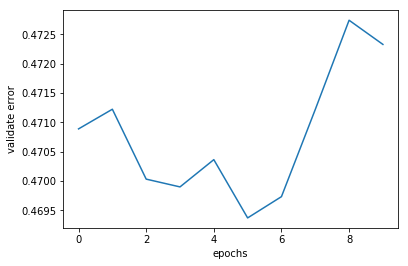

Visualize the outputs : 
Inputs : 


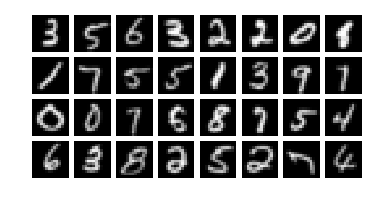

Outputs of G network : 


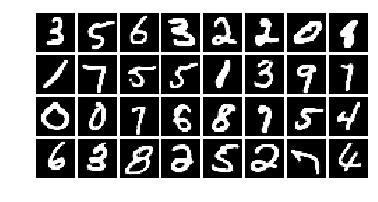

Origin :


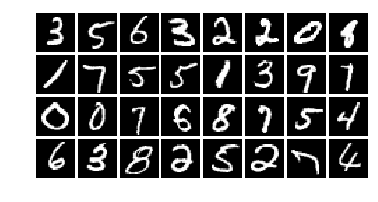

In [17]:
main(resume = 'G_best.pth.tar')

==> Setting parameters
lr : 0.01, betas : (0.9, 0.999)
Epochs : 10, best_prec1 : 10
==> Detecting GPU
False


==> Preparing models
==> loading checkpoint G_best.pth.tar
==> G_best.pth.tar has been loaded


Visualize the outputs : 
Inputs : 


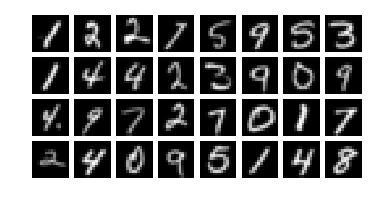

Outputs of G network : 


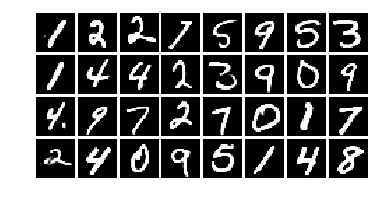

Origin :


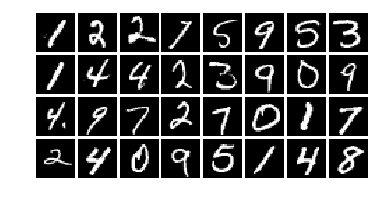

In [32]:
main(mode = 'visual', resume = 'G_best.pth.tar')

==> Setting parameters
lr : 0.01, betas : (0.9, 0.999)
Epochs : 10, best_prec1 : 10
==> Detecting GPU
False


==> Preparing models
==> loading checkpoint G_best.pth.tar
==> G_best.pth.tar has been loaded


Train with GAN
==> Starting Epoch 6
==> Starting Epoch 7
==> Starting Epoch 8
==> Starting Epoch 9
==> Starting Epoch 10
Visualize the outputs : 
Inputs : 


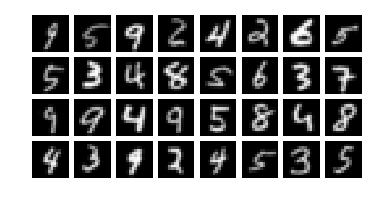

Outputs of G network : 


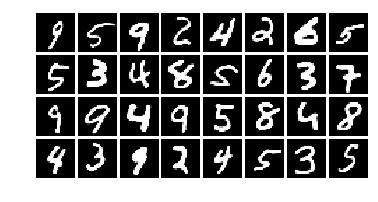

Origin :


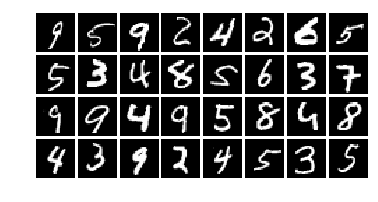

In [36]:
main(mode ='GAN', resume = 'G_best.pth.tar')

==> Setting parameters
lr : 0.01, betas : (0.9, 0.999)
Epochs : 10, best_prec1 : 10
==> Detecting GPU
False


==> Preparing models
==> loading checkpoint G_GAN.pth.tar
==> G_GAN.pth.tar has been loaded


Visualize the outputs : 
Inputs : 


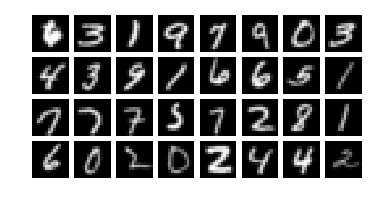

Outputs of G network : 


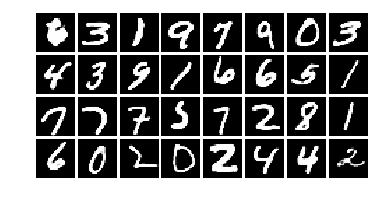

Origin :


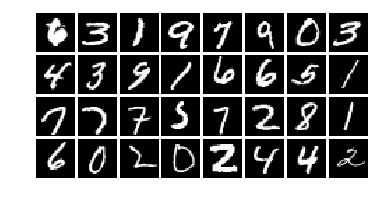

In [40]:
main(mode = 'visual', resume = 'G_GAN.pth.tar')

## Question
* how to dynamicly track losses and gradients

## Analysis
* Compare results from MSE and GAN, I found that the images generated from MSE is than images generated from GAN, which is more similar to the origin images. But the difference is not so big since my network is so strong and the results are very good even with MSE loss

In [7]:
print(type(True))

<class 'bool'>
